# Predict the states with AF2

### Boilerplate

In [1]:
%load_ext nb_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig107


<IPython.core.display.Javascript object>

### Get all decoys that had decent two state rosetta metrics
Hacky function to load JSON-like data

In [2]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "06_cleanup")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,HIS_burial_X,HIS_burial_Y,TRP_burial_X,TRP_burial_Y,X_nocys_path,X_path,X_seq,Y_nocys_path,Y_path,Y_seq,...,total_length,total_score,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_1c3348aaff704bdaa73c6d67fa2db82a.pdb.bz2,191.598892,161.116302,235.250000,221.223358,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAKELAEENDSEEVKRLL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAKELAEENDSCEVKRLL...,...,156.0,-200.714910,-495.980011,-490.601990,0.0,0.0,0.344967,0.369241,0.121823,0.108301
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_3d928f3daa034749a030c7e9ce8f40db.pdb.bz2,191.742218,190.977066,235.254822,219.012299,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAVELMRENPSEEVKRLV...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAVELMRENPSCEVKRLV...,...,156.0,15.583651,-518.669983,-505.704010,0.0,0.0,0.349388,0.696476,0.120602,0.129675
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_28be1bd66de54aed83f7639dcd62c32f.pdb.bz2,0.000000,0.000000,221.614243,242.966599,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DSEEEQERIRRILKEARKSGTEESLEQAIEDVAQLAKKSQDPRVLE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DSEEEQERIRRILKEARKSGTEESLEQAIEDVAQLAKKSQDPRVLE...,...,160.0,-205.345371,-548.015991,-559.239014,0.0,0.0,0.433880,0.644063,0.134351,0.108984
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_0762f62cd16741048a97cb9036adac58.pdb.bz2,0.000000,0.000000,218.944855,230.889313,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAWELVEENPSEEALRLL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAWELVEENPSCEALRLL...,...,156.0,-67.159011,-514.296997,-492.813995,0.0,0.0,0.353671,0.777966,0.124616,0.113692
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_394bedb1240946b9bbaf95c504a5e428.pdb.bz2,0.000000,0.000000,191.111252,208.557068,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TIEEIAAELKKTIKEAAEAGADEEAVKDARKLVKEVEKAAKRGVDE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TIEEIAAELKKTIKEAAEAGADEEAVKDARKLVKEVEKAAKRGVDE...,...,184.0,14.682345,-566.111023,-566.744995,0.0,0.0,0.687405,0.673628,0.122836,0.106946


<IPython.core.display.Javascript object>

### Refilter to remove accidentally introduced TRP
Could use `if row["final_sequence"].count("AAA") < 2:` to remove polyALA

In [3]:
idces = []
for i, row in tqdm(scores_df.iterrows()):
    if row["final_sequence"].count("W") == 1:
        idces.append(i)

one_trp = scores_df.loc[idces]
print(f"before refiltering: {len(scores_df)}, after filtering: {len(one_trp)}")

12617it [00:01, 10135.84it/s]

before refiltering: 12617, after filtering: 12602


<IPython.core.display.Javascript object>

### Make a list of state Y's to fold with AF2

In [4]:
with open(os.path.join(os.getcwd(), "06_cleanup", "1trp_refiltered_Y.list"), "w") as f:
    for i in one_trp.Y_path.values:
        print(i, file=f)

<IPython.core.display.Javascript object>

### Use AF2 to predict state Y's
if those have low RMSD and form disulfides, predict state X's,  
if those have low RMSD and form disulfides, predict state U's,  
then check RMSD to the X and Y state

In [6]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            tasks = {}
            path = file.rstrip()
            tasks["-s"] = path
            yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# cleanup old cmdslists
for cmdslist in glob(os.path.join(os.getcwd(), "07_run*.cmds")):
    os.remove(cmdslist)


infer = os.path.join(os.getcwd(), "run_af2_design_pdb.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for designs, mem, queue in [("state_Y", "10", "short")]:
    targets = os.path.join(os.getcwd(), f"06_cleanup/1trp_refiltered_Y.list")
    for i, tasks in enumerate(tqdm(create_tasks(targets))):
        if os.path.isfile(tasks["-s"].replace(".pdb", ".json")):
            continue
        else:
            pass
        tasklist = f"07_run_af2_{designs}_designs.cmds"
        gpu = ""
        queue = queue
        core_mem = f"#SBATCH --mem={mem}G \n"
        run_sh = """#!/usr/bin/env bash \n#SBATCH -J inference \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/infer-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/infer-%J.out \n#SBATCH -p {queue} \n{gpu}{core_mem}\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
            queue=queue,
            gpu=gpu,
            core_mem=core_mem,
            jid=jid,
            sid=sid,
            tasklist=tasklist,
            c="{CMD}",
        )
        shell = f"07_run_af2_{designs}_designs.sh"
        with open(shell, "w+") as f:
            print(run_sh, file=f)
        st = os.stat(shell)
        os.chmod(shell, st.st_mode | stat.S_IEXEC)
        with open(tasklist, "a+") as f:
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{infer} {args_} --save_pdbs"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
for i in "state_Y".split():
    print(
        f"sbatch -a 1-$(cat '07_run_af2_{i}_designs.cmds' | wc -l) '07_run_af2_{i}_designs.sh'"
    )

12602it [00:08, 1506.57it/s]

Run the following commands
sbatch -a 1-$(cat '07_run_af2_state_Y_designs.cmds' | wc -l) '07_run_af2_state_Y_designs.sh'


<IPython.core.display.Javascript object>

In [7]:
!sbatch -a 1-$(cat '07_run_af2_state_Y_designs.cmds' | wc -l) '07_run_af2_state_Y_designs.sh'

Submitted batch job 33883768


<IPython.core.display.Javascript object>

### Now need to retrieve the JSONs containing scores for the AF2 inference runs

In [2]:
%%time
import json, time


output_path = os.path.join(os.getcwd(), "06_states")
output_paths = glob(os.path.join(output_path, "*/*.json"))
print(f"reading {len(output_paths)} runs")
time.sleep(0.5)
scores = {}
for path in tqdm(output_paths):
    pdb = path.replace("json", "pdb")
    key = f"{pdb}"
    with open(path, "r") as f:
        try:
            values_dict = json.load(f)
            values = {}
            for model, results in values_dict.items():
                results.pop("pae") # pae is too big?
                for name, result in results.items():
                    values[name+"_"+model] = result
            del values_dict
        except:
            print(path)
    scores[key] = values
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_file = os.path.join(output_path, "scores.json")
scores_df.to_json(output_file)

reading 12496 runs


100%|██████████| 12496/12496 [22:30<00:00,  9.25it/s]


CPU times: user 19min 37s, sys: 26.7 s, total: 20min 4s
Wall time: 22min 37s


<IPython.core.display.Javascript object>

### Add additional columns incorporating metadata from best decoy by plDDT and lowest RMSD decoy

In [24]:
def row2best_model(
    row: pd.Series,
) -> str:
    best_model = "1"
    for model in "2345":
        if (
            row[f"average_plddts_model_{model}"]
            > row[f"average_plddts_model_{best_model}"]
        ):
            best_model = model
        else:
            pass
    return best_model


def row2best_metadata(row: pd.Series, **kwargs) -> float:
    best_model = row["best_model"]
    best_average_metadata = row[f"{key}_model_{best_model}"]
    return best_average_metadata


def row2lowest_rmsd_model(
    row: pd.Series,
) -> str:
    lowest_rmsd_model = "1"
    for model in "2345":
        if (
            row[f"rmsd_to_input_model_{model}"]
            < row[f"rmsd_to_input_model_{lowest_rmsd_model}"]
        ):
            lowest_rmsd_model = model
        else:
            pass
    return lowest_rmsd_model


def row2lowest_rmsd__metadata(row: pd.Series, **kwargs) -> float:
    lowest_rmsd_model = row["lowest_rmsd_model"]
    lowest_rmsd_metadata = row[f"{key}_model_{lowest_rmsd_model}"]
    return lowest_rmsd_metadata


def row2plddt_rmsd_agree(row: pd.Series) -> bool:
    if row["best_model"] == row["lowest_rmsd_model"]:
        return True
    else:
        return False


scores_df["best_model"] = scores_df.apply(row2best_model, axis=1)
scores_df["lowest_rmsd_model"] = scores_df.apply(row2lowest_rmsd_model, axis=1)
for key in tqdm(
    "average_plddts plddt ptm rmsd_to_input average_DAN_plddts DAN_plddt pdb_path".split()
):
    scores_df[f"best_{key}"] = scores_df.apply(
        row2best_metadata, kwargs={"key": key}, axis=1
    )
    scores_df[f"lowest_rmsd_{key}"] = scores_df.apply(
        row2lowest_rmsd__metadata, kwargs={"key": key}, axis=1
    )
scores_df["plddt_rmsd_agree"] = scores_df.apply(row2plddt_rmsd_agree, axis=1)

100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


<IPython.core.display.Javascript object>

### Dump df as json

In [25]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores.json")
scores_df.to_json(output_file)

<IPython.core.display.Javascript object>

### Reload df from disk

In [26]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(output_file)

<IPython.core.display.Javascript object>

### Distribute metadata collection to cluster with dask and collect results

In [27]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd


def distribute_get_dslf_fa13(pdb:str) -> float:
    pyrosetta.init("-corrections:beta_nov16 true")
    sfxn = pyrosetta.get_fa_scorefxn()
    pose = pyrosetta.io.pose_from_file(pdb)
    sfxn.score(pose)
    dslf_fa13 = pose.scores["dslf_fa13"]
    return dslf_fa13


pyrosetta.init("-corrections:beta_nov16 true")


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

subset = scores_df[scores_df["lowest_rmsd_rmsd_to_input"] < 1.5]

futures = {}
results = {}

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="2GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-200 workers,
        cluster.adapt(
            minimum=1,
            maximum=200,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            for path in subset.index:
                future = client.submit(distribute_get_dslf_fa13, path)
                futures[path] = future
            for i, pending in futures.items():
                result = pending.result()
                results[i] = result

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.27+release.7ce64884a77d606b7b667c363527acc846541030 2021-07-09T18:10:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release r289 2021.27+release.7ce6488 7ce64884a77d606b7b667c363527acc846541030 http://www.pyrosetta.org 2021-07-09T18:10:05
core.init: {0} command: PyRosetta -corrections:beta_nov16 true -database /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=-549098848 seed_offset=0 real_seed=-549098848 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=-5490988

<IPython.core.display.Javascript object>

In [28]:
scores_df["dslf_fa13"] = pd.Series(results)

<IPython.core.display.Javascript object>

### Dump df as json

In [29]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores.json")
scores_df.to_json(output_file)

<IPython.core.display.Javascript object>

### Reload df from disk

In [2]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(output_file)

<IPython.core.display.Javascript object>

### Get state Y's that have low RMSD for at least one prediction and have formed disulfides

In [3]:
good_state_Y = scores_df[scores_df["lowest_rmsd_rmsd_to_input"] < 1.5]
good_state_Y = good_state_Y[good_state_Y["dslf_fa13"] < 0]
good_state_Y["lowest_rmsd_model"] = "model_" + good_state_Y["lowest_rmsd_model"].astype(str)

<IPython.core.display.Javascript object>

### Make a list of state X's to fold with AF2

In [4]:
with open(os.path.join(os.getcwd(), "06_cleanup", "good_state_Y.list"), "w") as f:
    for i in good_state_Y.index:
        print(i.replace("Y", "X"), file=f)

<IPython.core.display.Javascript object>

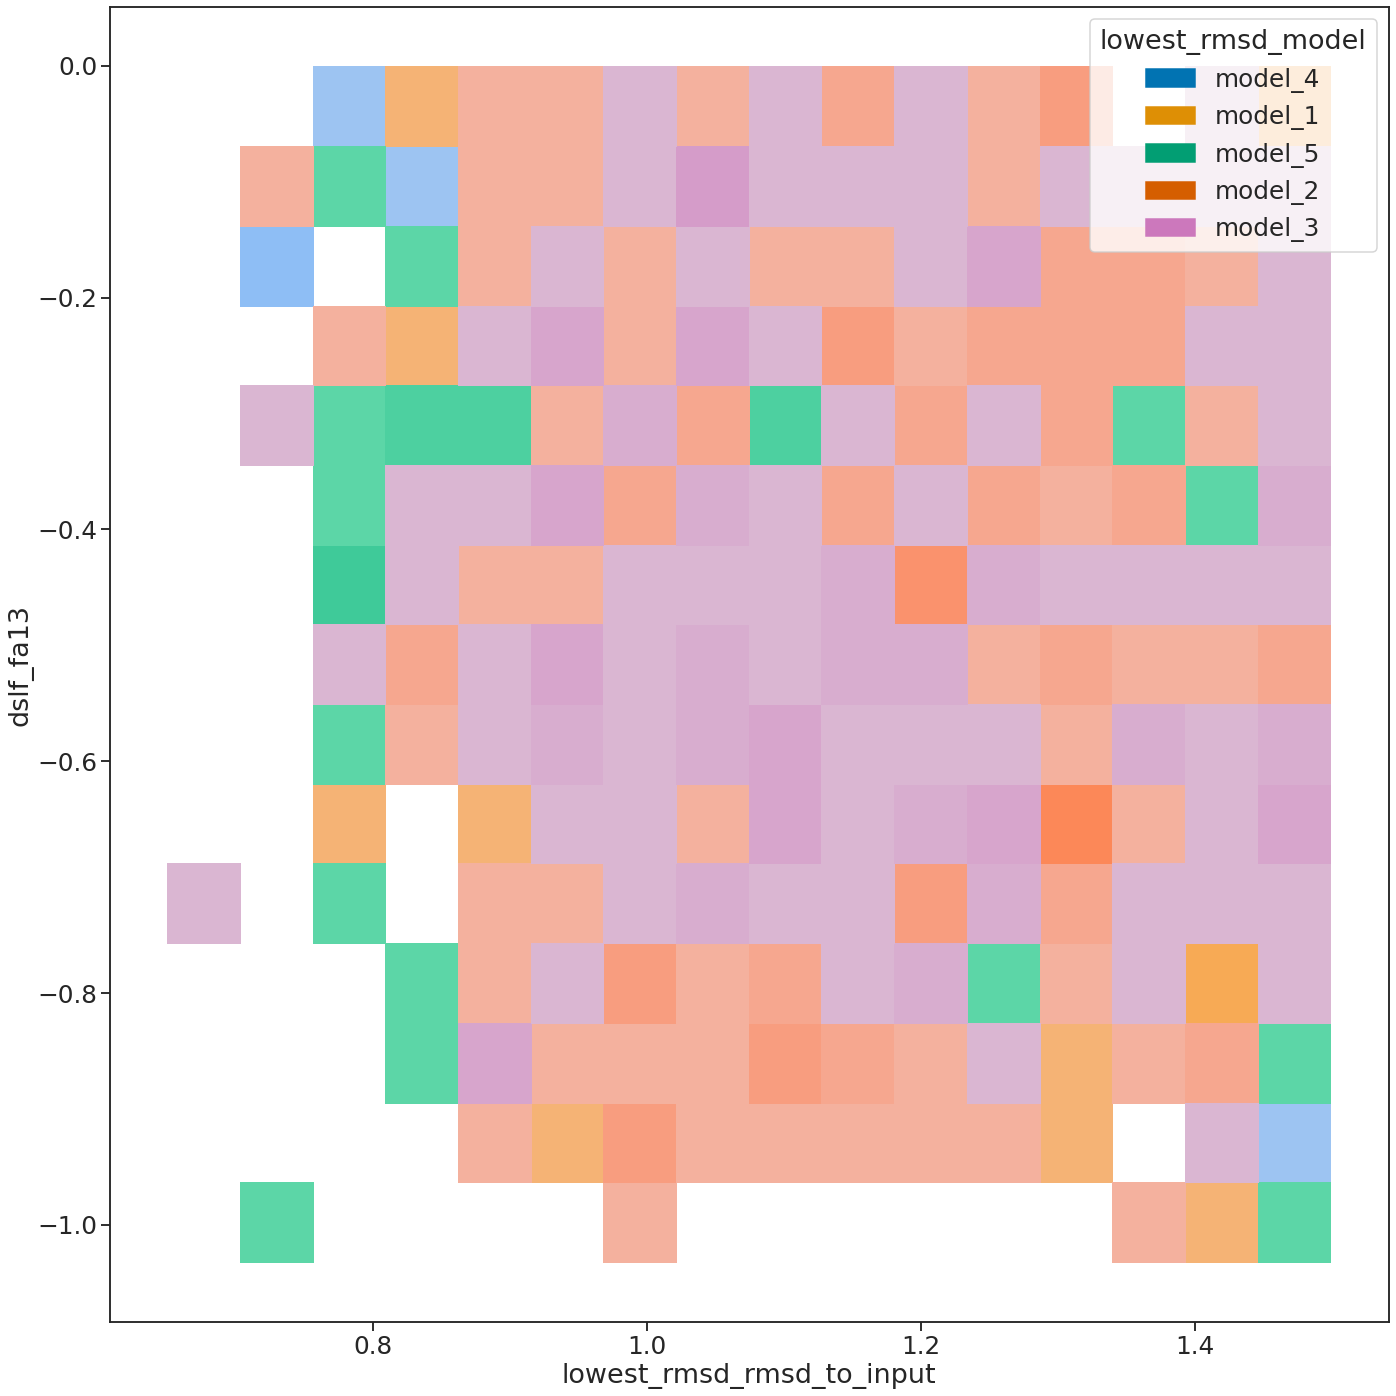

<IPython.core.display.Javascript object>

In [5]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
fig = plt.figure(figsize=(20, 20), tight_layout=True)
_ = sns.histplot(data=good_state_Y, x="lowest_rmsd_rmsd_to_input", y="dslf_fa13", hue="lowest_rmsd_model")

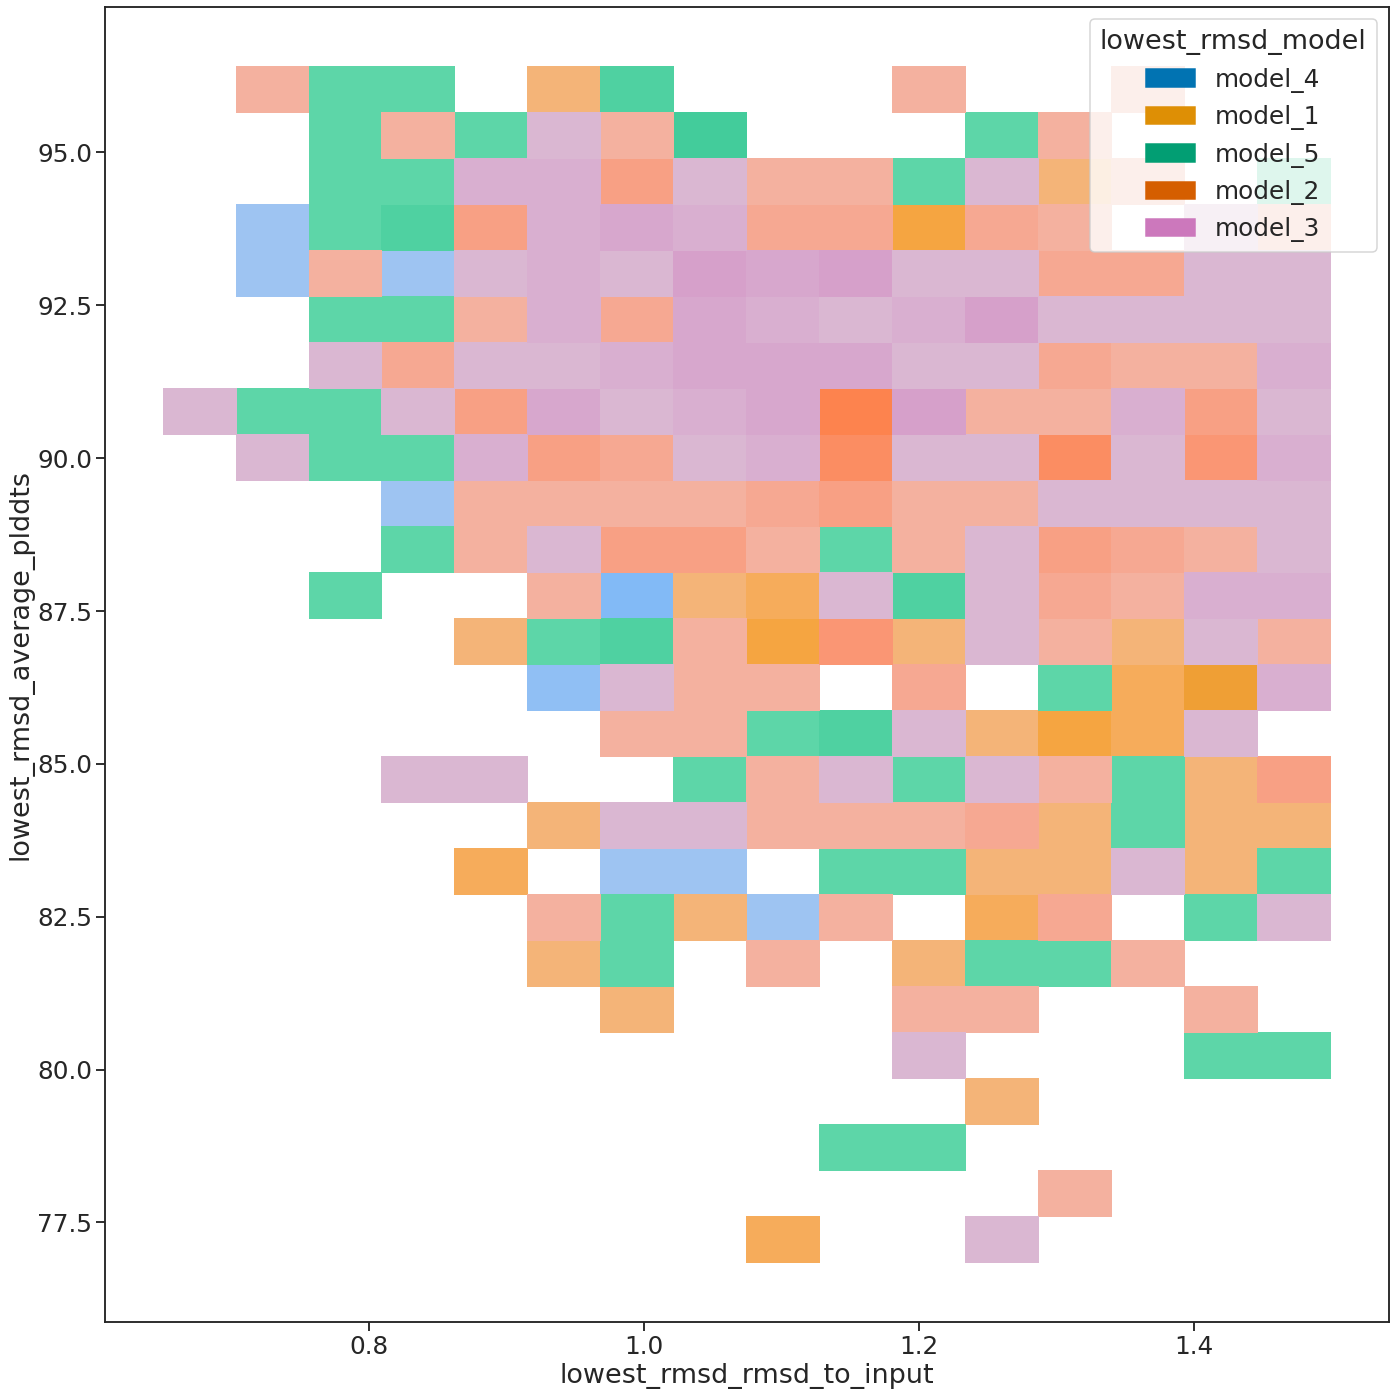

<IPython.core.display.Javascript object>

In [6]:
fig = plt.figure(figsize=(20, 20), tight_layout=True)
_ = sns.histplot(data=good_state_Y, x="lowest_rmsd_rmsd_to_input", y="lowest_rmsd_average_plddts", hue="lowest_rmsd_model")

### Use AF2 to predict state X's
if those have low RMSD and form disulfides, predict state U's,  
then check RMSD to the X and Y state

In [7]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            tasks = {}
            path = file.rstrip()
            tasks["-s"] = path
            yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# cleanup old cmdslists
for cmdslist in glob(os.path.join(os.getcwd(), "07_run*state_X*.cmds")):
    os.remove(cmdslist)


infer = os.path.join(os.getcwd(), "run_af2_design_pdb.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for designs, mem, queue in [("state_X", "12", "short")]:
    targets = os.path.join(os.getcwd(), f"06_cleanup/good_state_Y.list")
    for i, tasks in enumerate(tqdm(create_tasks(targets))):
        if os.path.isfile(tasks["-s"].replace(".pdb", ".json")):
            continue
        else:
            pass
        tasklist = f"07_run_af2_{designs}_designs.cmds"
        gpu = ""
        queue = queue
        core_mem = f"#SBATCH --mem={mem}G \n"
        run_sh = """#!/usr/bin/env bash \n#SBATCH -J inference \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/infer-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/infer-%J.out \n#SBATCH -p {queue} \n{gpu}{core_mem}\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
            queue=queue,
            gpu=gpu,
            core_mem=core_mem,
            jid=jid,
            sid=sid,
            tasklist=tasklist,
            c="{CMD}",
        )
        shell = f"07_run_af2_{designs}_designs.sh"
        with open(shell, "w+") as f:
            print(run_sh, file=f)
        st = os.stat(shell)
        os.chmod(shell, st.st_mode | stat.S_IEXEC)
        with open(tasklist, "a+") as f:
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{infer} {args_} --save_pdbs"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
for i in "state_X".split():
    print(
        f"sbatch -a 1-$(cat '07_run_af2_{i}_designs.cmds' | wc -l) '07_run_af2_{i}_designs.sh'"
    )

1163it [00:01, 1029.97it/s]

Run the following commands
sbatch -a 1-$(cat '07_run_af2_state_X_designs.cmds' | wc -l) '07_run_af2_state_X_designs.sh'


<IPython.core.display.Javascript object>

In [9]:
!sbatch -a 1-$(cat '07_run_af2_state_X_designs.cmds' | wc -l) '07_run_af2_state_X_designs.sh'


Submitted batch job 34585972


<IPython.core.display.Javascript object>

### Now need to retrieve the JSONs containing scores for the AF2 inference runs

In [3]:
%%time
import json, time


output_path = os.path.join(os.getcwd(), "06_states")
output_paths = glob(os.path.join(output_path, "*/*X*.json"))
print(f"reading {len(output_paths)} runs")
time.sleep(0.5)
scores = {}
for path in tqdm(output_paths):
    pdb = path.replace("json", "pdb")
    key = f"{pdb}"
    with open(path, "r") as f:
        try:
            values_dict = json.load(f)
            values = {}
            for model, results in values_dict.items():
                results.pop("pae") # pae is too big?
                for name, result in results.items():
                    values[name+"_"+model] = result
            del values_dict
        except:
            print(path)
    scores[key] = values
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_file = os.path.join(output_path, "scores_X.json")
scores_df.to_json(output_file)

reading 1163 runs


100%|██████████| 1163/1163 [02:45<00:00,  7.02it/s]


CPU times: user 2min 11s, sys: 3.23 s, total: 2min 14s
Wall time: 2min 46s


<IPython.core.display.Javascript object>

### Add additional columns incorporating metadata from best decoy by plDDT and lowest RMSD decoy

In [4]:
def row2best_model(
    row: pd.Series,
) -> str:
    best_model = "1"
    for model in "2345":
        if (
            row[f"average_plddts_model_{model}"]
            > row[f"average_plddts_model_{best_model}"]
        ):
            best_model = model
        else:
            pass
    return best_model


def row2best_metadata(row: pd.Series, **kwargs) -> float:
    best_model = row["best_model"]
    best_average_metadata = row[f"{key}_model_{best_model}"]
    return best_average_metadata


def row2lowest_rmsd_model(
    row: pd.Series,
) -> str:
    lowest_rmsd_model = "1"
    for model in "2345":
        if (
            row[f"rmsd_to_input_model_{model}"]
            < row[f"rmsd_to_input_model_{lowest_rmsd_model}"]
        ):
            lowest_rmsd_model = model
        else:
            pass
    return lowest_rmsd_model


def row2lowest_rmsd__metadata(row: pd.Series, **kwargs) -> float:
    lowest_rmsd_model = row["lowest_rmsd_model"]
    lowest_rmsd_metadata = row[f"{key}_model_{lowest_rmsd_model}"]
    return lowest_rmsd_metadata


def row2plddt_rmsd_agree(row: pd.Series) -> bool:
    if row["best_model"] == row["lowest_rmsd_model"]:
        return True
    else:
        return False


scores_df["best_model"] = scores_df.apply(row2best_model, axis=1)
scores_df["lowest_rmsd_model"] = scores_df.apply(row2lowest_rmsd_model, axis=1)
for key in tqdm(
    "average_plddts plddt ptm rmsd_to_input average_DAN_plddts DAN_plddt pdb_path".split()
):
    scores_df[f"best_{key}"] = scores_df.apply(
        row2best_metadata, kwargs={"key": key}, axis=1
    )
    scores_df[f"lowest_rmsd_{key}"] = scores_df.apply(
        row2lowest_rmsd__metadata, kwargs={"key": key}, axis=1
    )
scores_df["plddt_rmsd_agree"] = scores_df.apply(row2plddt_rmsd_agree, axis=1)

100%|██████████| 7/7 [00:00<00:00, 24.97it/s]


<IPython.core.display.Javascript object>

### Dump df as json

In [5]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores_X.json")
scores_df.to_json(output_file)

<IPython.core.display.Javascript object>

### Reload df from disk

In [6]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores_X.json")
scores_df = pd.read_json(output_file)

<IPython.core.display.Javascript object>

### Distribute metadata collection to cluster with dask and collect results

In [7]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd


def distribute_get_dslf_fa13(pdb:str) -> float:
    pyrosetta.init("-corrections:beta_nov16 true")
    sfxn = pyrosetta.get_fa_scorefxn()
    pose = pyrosetta.io.pose_from_file(pdb)
    sfxn.score(pose)
    dslf_fa13 = pose.scores["dslf_fa13"]
    return dslf_fa13


pyrosetta.init("-corrections:beta_nov16 true")


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

futures = {}
results = {}

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="2GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-200 workers,
        cluster.adapt(
            minimum=1,
            maximum=200,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            for path in scores_df.index:
                future = client.submit(distribute_get_dslf_fa13, path)
                futures[path] = future
            for i, pending in futures.items():
                result = pending.result()
                results[i] = result

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.27+release.7ce64884a77d606b7b667c363527acc846541030 2021-07-09T18:10:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release r289 2021.27+release.7ce6488 7ce64884a77d606b7b667c363527acc846541030 http://www.pyrosetta.org 2021-07-09T18:10:05
core.init: {0} command: PyRosetta -corrections:beta_nov16 true -database /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=-1730518657 seed_offset=0 real_seed=-1730518657 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=-17305

<IPython.core.display.Javascript object>

In [8]:
scores_df["dslf_fa13"] = pd.Series(results)

<IPython.core.display.Javascript object>

### Dump df as json

In [9]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores_X.json")
scores_df.to_json(output_file)

<IPython.core.display.Javascript object>

### Reload df from disk

In [10]:
output_path = os.path.join(os.getcwd(), "06_states")
output_file = os.path.join(output_path, "scores_X.json")
scores_df = pd.read_json(output_file)

<IPython.core.display.Javascript object>

### Get state X's that have low RMSD for at least one prediction and have formed disulfides

In [11]:
good_state_X = scores_df[scores_df["lowest_rmsd_rmsd_to_input"] < 1.5]
good_state_X = good_state_X[good_state_X["dslf_fa13"] < 0]
good_state_X["lowest_rmsd_model"] = "model_" + good_state_X["lowest_rmsd_model"].astype(str)

<IPython.core.display.Javascript object>

### Make a list of state U's to fold with AF2

In [19]:
with open(os.path.join(os.getcwd(), "06_cleanup", "good_state_X.list"), "w") as f:
    for i in good_state_X.index:
        print(i.replace("X", "X_nocys"), file=f)
        print(i.replace("X", "Y_nocys"), file=f)

<IPython.core.display.Javascript object>

### Use AF2 to predict state U's
then check RMSD to the X and Y state

In [20]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            tasks = {}
            path = file.rstrip()
            tasks["-s"] = path
            yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# cleanup old cmdslists
for cmdslist in glob(os.path.join(os.getcwd(), "07_run*state_U*.cmds")):
    os.remove(cmdslist)


infer = os.path.join(os.getcwd(), "run_af2_design_pdb.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for designs, mem, queue in [("state_U", "12", "medium")]:
    targets = os.path.join(os.getcwd(), f"06_cleanup/good_state_X.list")
    for i, tasks in enumerate(tqdm(create_tasks(targets))):
        if os.path.isfile(tasks["-s"].replace(".pdb", ".json")):
            continue
        else:
            pass
        tasklist = f"07_run_af2_{designs}_designs.cmds"
        gpu = ""
        queue = queue
        core_mem = f"#SBATCH --mem={mem}G \n"
        run_sh = """#!/usr/bin/env bash \n#SBATCH -J inference \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/infer-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/infer-%J.out \n#SBATCH -p {queue} \n{gpu}{core_mem}\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
            queue=queue,
            gpu=gpu,
            core_mem=core_mem,
            jid=jid,
            sid=sid,
            tasklist=tasklist,
            c="{CMD}",
        )
        shell = f"07_run_af2_{designs}_designs.sh"
        with open(shell, "w+") as f:
            print(run_sh, file=f)
        st = os.stat(shell)
        os.chmod(shell, st.st_mode | stat.S_IEXEC)
        with open(tasklist, "a+") as f:
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{infer} {args_} --save_pdbs"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
for i in "state_U".split():
    print(
        f"sbatch -a 1-$(cat '07_run_af2_{i}_designs.cmds' | wc -l) '07_run_af2_{i}_designs.sh'"
    )

176it [00:00, 913.02it/s]


Run the following commands
sbatch -a 1-$(cat '07_run_af2_state_U_designs.cmds' | wc -l) '07_run_af2_state_U_designs.sh'


<IPython.core.display.Javascript object>

### Unused blocks

### Setup for plotting

In [3]:
def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


def plot_unity_0(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    #     xmin, ymin = (xdata.min(), ydata.min())
    xmin, ymin = 0, 0
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
figs_dir = os.path.join(os.getcwd(), "figs")

os.makedirs(figs_dir, exist_ok=True)

<IPython.core.display.Javascript object>

### Plot results

In [19]:
sum(list(scores_df.plddt_rmsd_agree.values))/len(scores_df)

0.1925416133162612

<IPython.core.display.Javascript object>